In [1]:
# 1. Download the MNIST Dataset

In [2]:
#  build, train, and evaluate a Convolutional Neural Network (CNN) for handwritten digit recognition using the MNIST dataset
# Import other packages/libraries too
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torchsummary import summary
import random
import time

In [3]:
# Check if GPU is available, use if so or use cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print device in use
print(f"Using device: {device}")

Using device: cpu


In [4]:
## 2. Prepare the Data

### 2.1 Introduce the MNIST Dataset
"""
The MNIST dataset is a collection of handwritten digits widely used for training and testing 
machine learning models. It includes tens of thousands of training and test images, and 10 classes with digits 0-9.
Each image is a 28x28 grayscale image which implies 1 channel. Dataset is normalized for improved training and convergence.
"""

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Mean and std of MNIST
])

# Download and load the training and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [5]:
### 2.2 MNIST Dataset Introduction

# print the MNIST dataset sizes
print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Image dimensions: {train_dataset[0][0].shape}")

Training dataset size: 60000
Test dataset size: 10000
Number of classes: 10
Image dimensions: torch.Size([1, 28, 28])


In [6]:
### 2.3 Create DataLoaders

# Define batch size for conveinience
batch_size = 64

# Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

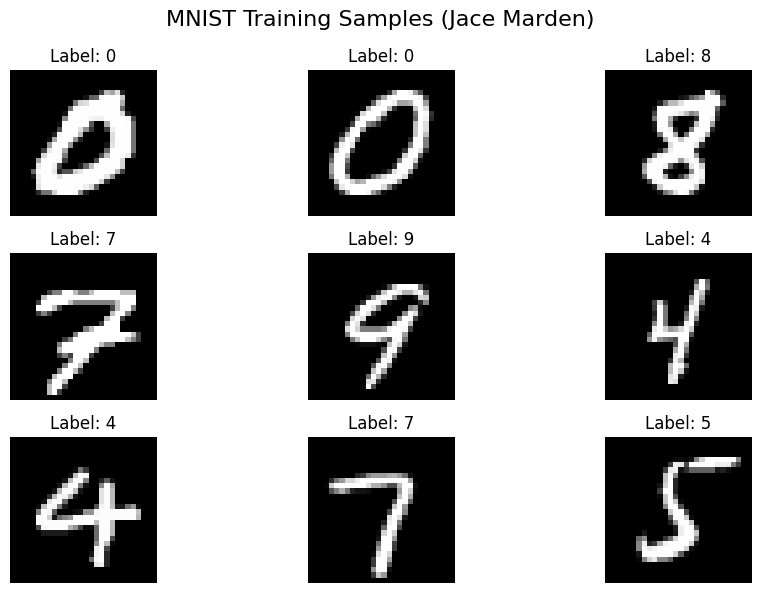

In [7]:
### 2.4 Visualize the Processed Data

# Function to visualize samples
def visualize_samples(dataloader, title):
    examples = iter(dataloader)
    example_data, example_targets = next(examples)
    
    fig = plt.figure(figsize=(10, 6))
    fig.suptitle(f"{title} (Jace Marden)", fontsize=16)
    
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(example_data[i][0], cmap='gray')
        plt.title(f"Label: {example_targets[i]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

# Visualize training samples
visualize_samples(train_loader, "MNIST Training Samples")

In [8]:
## 3. Build a CNN Model
### 3.1 Define the CNN Model Structure

class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()

        #Instructions say to design our own CNN so I looked up a bunch of possible functions
        # Then looked up how to connect them, so hopefully this does something
        
        # First Convolutional Block
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Second Convolutional Block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Third Convolutional Block
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x)
        return x

In [9]:
# Create the model and move it to the device
model = MNISTClassifier().to(device)

In [10]:
### 3.2 Set Up the Trainer
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() #CEL
optimizer = optim.Adam(model.parameters(), lr=0.001) #Adam

# Learning rate scheduler
# Had to look up how to implemenet a learning rate scheduler which was interesting
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=5, verbose=True
)

C:\Users\stell\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [11]:
### 3.3 Summarize the Model
# Display model summary using torchsummary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          18,496
       BatchNorm2d-6           [-1, 64, 14, 14]             128
              ReLU-7           [-1, 64, 14, 14]               0
         MaxPool2d-8             [-1, 64, 7, 7]               0
            Conv2d-9            [-1, 128, 7, 7]          73,856
      BatchNorm2d-10            [-1, 128, 7, 7]             256
             ReLU-11            [-1, 128, 7, 7]               0
        MaxPool2d-12            [-1, 128, 3, 3]               0
          Flatten-13                 [-1, 1152]               0
           Linear-14                  [

In [12]:
### 3.4 Training function to train the model (50 epochs was minimum even though it takes 
#Ensure loss is monitored and tracked during training 
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=50):
    # Lists to track metrics
    train_losses = []
    test_losses = []
    test_accuracies = []
    
    # Training loop
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if (i + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}, Accuracy: {100 * correct / total:.2f}%')
        
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        
        # Validation phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_test_loss = test_loss / len(test_loader)
        test_losses.append(epoch_test_loss)
        
        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
        
        # Update scheduler
        scheduler.step(epoch_test_loss)
        
        # Print epoch statistics
        end_time = time.time()
        epoch_time = end_time - start_time
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}, '
              f'Test Accuracy: {accuracy:.2f}%, Time: {epoch_time:.2f}s')
    
    return train_losses, test_losses, test_accuracies

In [13]:
## 3.4.2 Train the Model with the trainer function
# Set number of epochs
num_epochs = 50
# Train the model
train_losses, test_losses, test_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs
)

Epoch [1/50], Step [100/938], Loss: 0.0921, Accuracy: 82.59%
Epoch [1/50], Step [200/938], Loss: 0.0672, Accuracy: 88.95%
Epoch [1/50], Step [300/938], Loss: 0.3501, Accuracy: 91.41%
Epoch [1/50], Step [400/938], Loss: 0.0613, Accuracy: 92.70%
Epoch [1/50], Step [500/938], Loss: 0.0144, Accuracy: 93.54%
Epoch [1/50], Step [600/938], Loss: 0.1846, Accuracy: 94.18%
Epoch [1/50], Step [700/938], Loss: 0.0470, Accuracy: 94.67%
Epoch [1/50], Step [800/938], Loss: 0.0447, Accuracy: 95.07%
Epoch [1/50], Step [900/938], Loss: 0.0896, Accuracy: 95.39%
Epoch [1/50], Train Loss: 0.1466, Test Loss: 0.0727, Test Accuracy: 97.65%, Time: 123.63s
Epoch [2/50], Step [100/938], Loss: 0.0935, Accuracy: 98.28%
Epoch [2/50], Step [200/938], Loss: 0.0117, Accuracy: 98.14%
Epoch [2/50], Step [300/938], Loss: 0.0514, Accuracy: 98.15%
Epoch [2/50], Step [400/938], Loss: 0.0781, Accuracy: 98.26%
Epoch [2/50], Step [500/938], Loss: 0.0180, Accuracy: 98.25%
Epoch [2/50], Step [600/938], Loss: 0.0752, Accuracy: 98

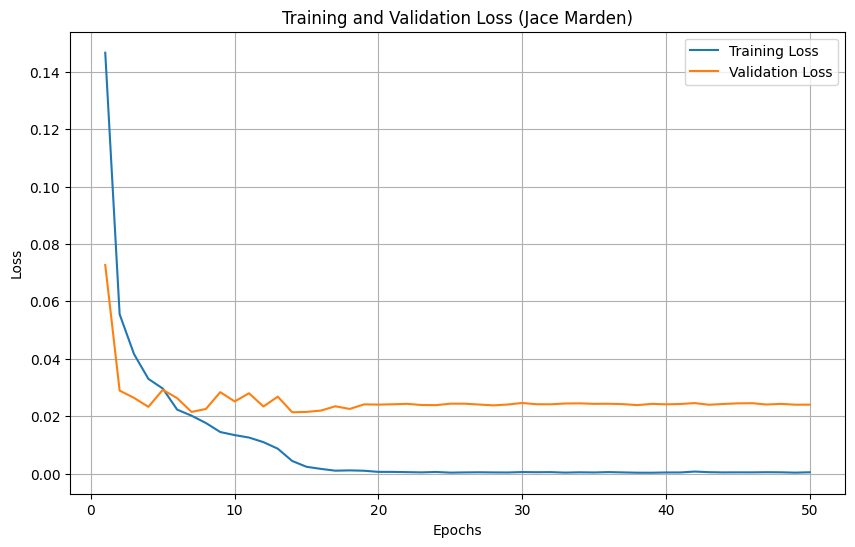

In [14]:
## 4. Visualize and Evaluate (at least 5 visulizations) (need name in titles)
### 4.1 Plot Training and Validation Loss over epochs from before
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Jace Marden)')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
#validation loss does not decrease and fluctuates wildly for epoches 4-15 meaning possible underfitting
#training loss is very low but validation loss only increases slightly at start, possibly overfitting but unlikely, however gap between curve means possible
#overally seems to be a good fit sense both training/validation stabilize

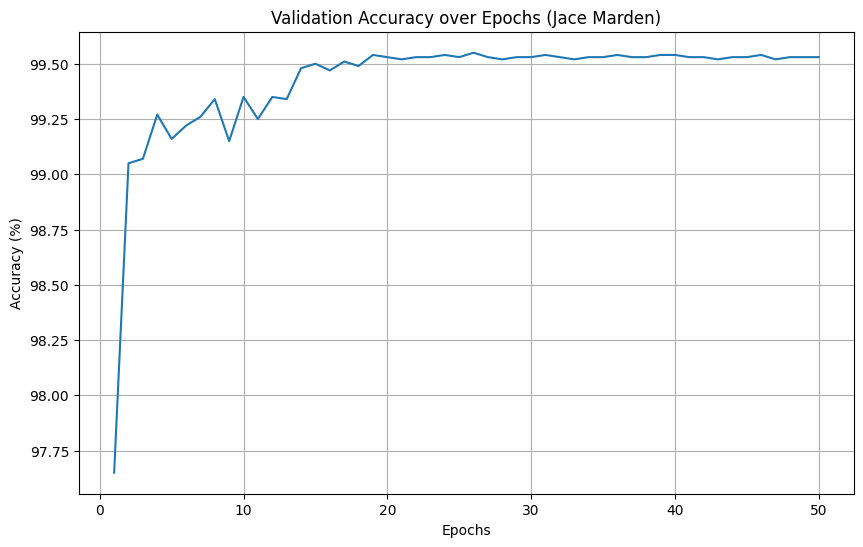

In [15]:
### 4.2 Plot Validation Accuracy over epochs from before
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), test_accuracies)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy over Epochs (Jace Marden)')
plt.grid(True)
plt.show()

In [22]:
#validation starts fairly decent gets near perfect, hand sanitizer levels

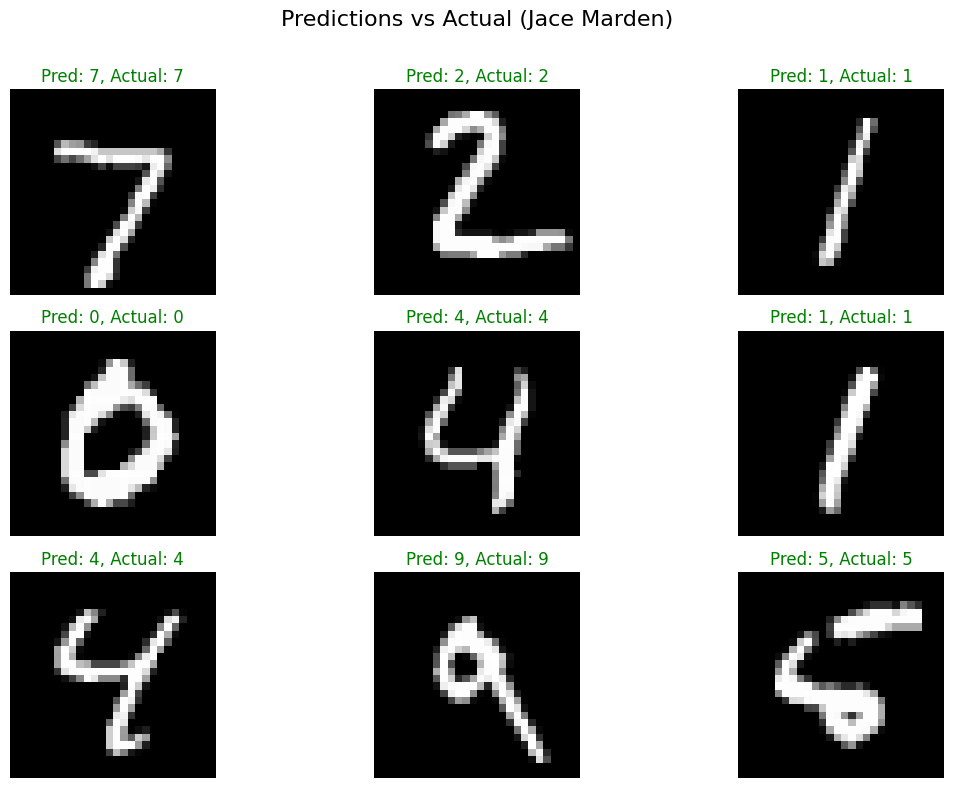

In [16]:
### 4.3 Visualize Predictions vs Actual
def visualize_predictions(model, test_loader, num_samples=9):
    # Get a batch of test data
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    
    # Move to device
    images, labels = images.to(device), labels.to(device)
    
    # Make predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    # Move back to CPU for visualization
    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()
    
    # Plot
    fig = plt.figure(figsize=(12, 8))
    fig.suptitle('Predictions vs Actual (Jace Marden)', fontsize=16)
    
    for i in range(num_samples):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i][0], cmap='gray')
        
        if predicted[i] == labels[i]:
            color = 'green'
        else:
            color = 'red'
            
        plt.title(f'Pred: {predicted[i]}, Actual: {labels[i]}', color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

# Visualize some predictions
visualize_predictions(model, test_loader)

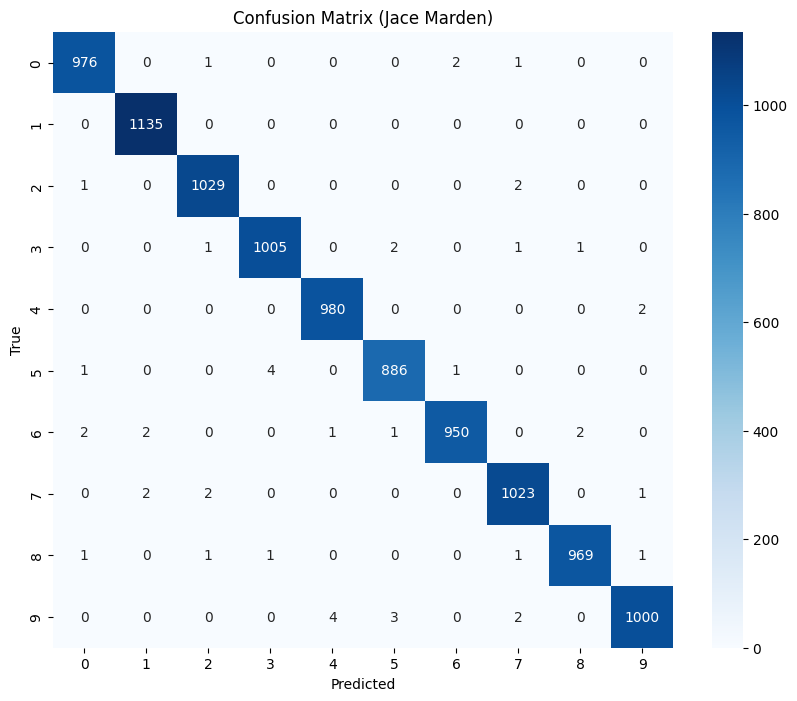

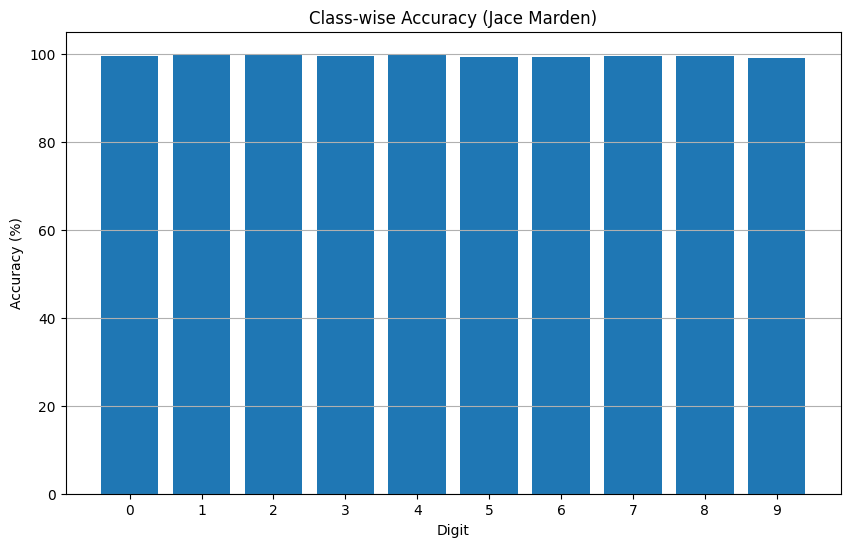

In [17]:
### 4.4 Confusion Matrix visualize
def plot_confusion_matrix(model, test_loader):
    # Lists to store predictions and true labels
    y_pred = []
    y_true = []
    
    # Iterate over test data
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Jace Marden)')
    plt.show()
    
    # Calculate class-wise accuracy
    class_accuracy = cm.diagonal() / cm.sum(axis=1) * 100
    
    # Plot class-wise accuracy
    plt.figure(figsize=(10, 6))
    plt.bar(range(10), class_accuracy)
    plt.xlabel('Digit')
    plt.ylabel('Accuracy (%)')
    plt.title('Class-wise Accuracy (Jace Marden)')
    plt.xticks(range(10))
    plt.grid(axis='y')
    plt.show()

# Create confusion matrix
plot_confusion_matrix(model, test_loader)

In [24]:
#it appears 9 and 5 got misclassified the most
#this makes sense as a 5 looks super similar to 3 and 9 to 4 which is what occured in prediction

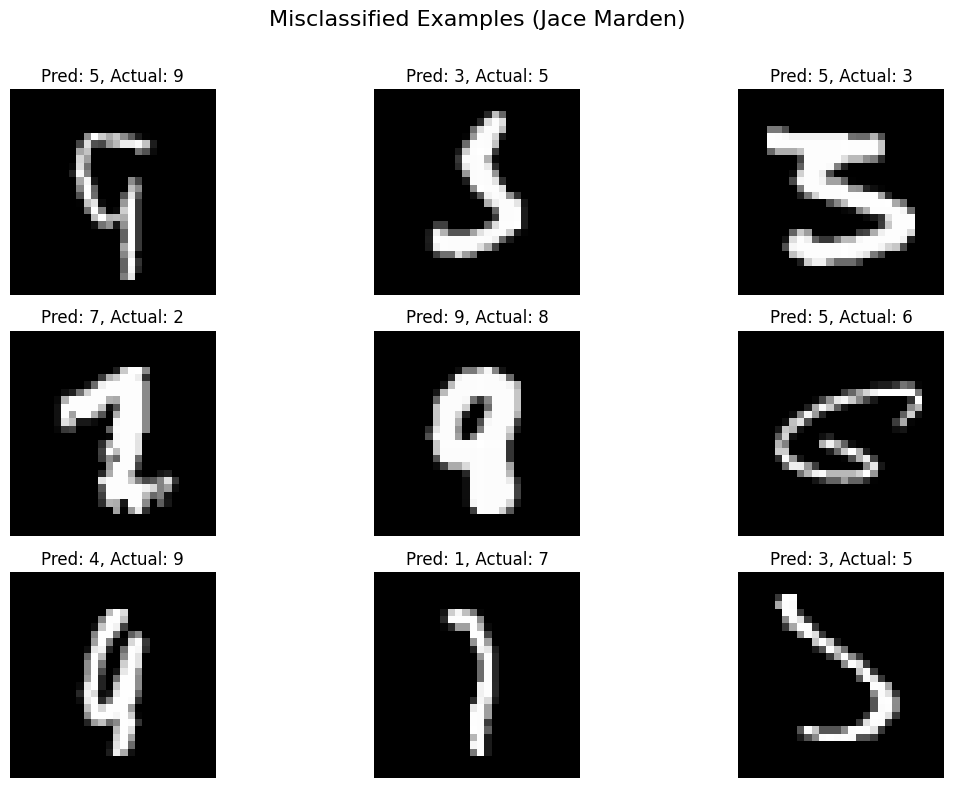

In [18]:
### 4.5 Visualize Misclassified Examples (had to kinda look this one up)
def visualize_misclassified(model, test_loader, num_samples=9):
    # Get all misclassified examples
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Find misclassified examples
            incorrect_idx = (predicted != labels).nonzero(as_tuple=True)[0]
            
            for idx in incorrect_idx:
                misclassified_images.append(inputs[idx].cpu())
                misclassified_labels.append(labels[idx].item())
                misclassified_preds.append(predicted[idx].item())
                
                # Break if we have enough samples
                if len(misclassified_images) >= num_samples:
                    break
            
            if len(misclassified_images) >= num_samples:
                break
    
    # Plot misclassified examples
    fig = plt.figure(figsize=(12, 8))
    fig.suptitle('Misclassified Examples (Jace Marden)', fontsize=16)
    
    for i in range(min(num_samples, len(misclassified_images))):
        plt.subplot(3, 3, i+1)
        plt.imshow(misclassified_images[i][0], cmap='gray')
        plt.title(f'Pred: {misclassified_preds[i]}, Actual: {misclassified_labels[i]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

# Visualize misclassified examples
visualize_misclassified(model, test_loader)

In [25]:
#Model appears to perform well on the test set, starting out with lower (80s) accuracy and quickly rising to be 90s and almost perfect quickly
#Misclassified shows what the incorrect predictions look like properly
#Classwise accuracy graph is hard to make look good since there is so much positive
# but confusion matrix is good at showing the sheer number of correct predictions over incorrect
#overall model appears to be a good fit and has a 99.99% accuracy after 50 epochs

In [20]:
## 5. Save the Model and upload with notebook file
# Save the model
torch.save(model.state_dict(), 'marden_mnist_cnn_model.pth') #change name if not want to delete but retrain
print("Model saved successfully!")

Model saved successfully!
